# Distribuição de estabelecimentos religiosos por setores censitários

Com base nos dados do Censo Demográfico 2022, divulgados pelo IBGE, implementamos rotinas em Python para mapeamento dos estabelecimentos religiosos em Juiz de Fora/MG.

### Coleta de dados

**Malha de setores censitários**

Caminho para baixar a malha de setores censitários:<br>
Página Principal -> Geociências -> Organização do território 
-> Estrutura territorial ->  Malha de Setores Censitários <br>
Selecione o formato de arquivo desejado: Malha de Setores Censitários – por UF (shp | gpkg | kml)<br><br>
Ou acesse o link:<br>
https://www.ibge.gov.br/geociencias/downloads-geociencias.html?caminho=organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2022/setores/shp/UF<br>
e selecione o arquivo da UF desejada

**Cadastro Nacional de Endereços para Fins Estatísticos**

Caminho para baixar Cadastro Nacional de Endereços para Fins Estatísticos: <br>
Página Principal -> Estatísticas -> Sociais -> População ->  CNEFE - Cadastro Nacional de Endereços para Fins Estatísticos.

Ou acesse o link:<br>
https://www.ibge.gov.br/estatisticas/sociais/populacao/38734-cadastro-nacional-de-enderecos-para-fins-estatisticos.html?=&t=downloads<br>
Clique em "Censo_Demográfico_2022" -> Arquivos_CNEFE<br>
Selecione o formato desejado<br>
Escolha a Unidade Territorial(Município)<br>
Selecione a UF<br>
Baixe o arquivo compactado do município desejado

## Importamos as bibiotecas

In [4]:
import json
import geopandas as gpd
import branca.colormap as cm
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import folium
from folium.plugins import MarkerCluster
from tqdm import tqdm  # Para barra de progresso (opcional)
import os


### Visualizamos os dados em clusters

Um *clustering map* ou mapa de agrupamentos é uma técnica de visualização cartográfica que agrega pontos geográficos ou dados espaciais em grupos (*clusters*), com base em critérios como proximidade, densidade ou atributos similares

In [5]:
# 1. Extrair e filtrar os dados
with zipfile.ZipFile('3136702_JUIZ_DE_FORA.zip') as z:
    with z.open('3136702_JUIZ_DE_FORA.csv') as f:
        # Ler em chunks para economizar memória
        chunks = pd.read_csv(f, 
                            sep=';',
                            chunksize=10000,
                            usecols=['COD_ESPECIE', 'DSC_ESTABELECIMENTO', 'LATITUDE', 'LONGITUDE'])
        
        # Filtrar e concatenar os chunks
        filtered_data = pd.concat([chunk[chunk['COD_ESPECIE'] == 8] for chunk in chunks])

# 2. Criar o mapa
# Calcular o centro inicial do mapa (média das coordenadas)
map_center = [filtered_data['LATITUDE'].mean(), filtered_data['LONGITUDE'].mean()]

# Criar mapa Folium
m = folium.Map(location=map_center, 
               zoom_start=13,
               tiles='OpenStreetMap')

# Adicionar cluster de marcadores para melhor performance
marker_cluster = MarkerCluster().add_to(m)

# Ícone personalizado de igreja
church_icon = folium.Icon(icon='church', 
                          prefix='fa', 
                          color='blue', 
                          icon_color='white')

# 3. Adicionar marcadores ao mapa
for idx, row in filtered_data.iterrows():
    # Verificar se as coordenadas são válidas
    if pd.notnull(row['LATITUDE']) and pd.notnull(row['LONGITUDE']):
        folium.Marker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            popup=row['DSC_ESTABELECIMENTO'],
            icon=church_icon
        ).add_to(marker_cluster)

# 4. Exibir o mapa
display(m)  # Para Jupyter Notebook/Lab
m.save('igrejas_juiz_de_fora.html')  # Para salvar como HTML

### Shapefile do município

Um shapefile (.shp) é um arquivo digital que contém a representação geográfica vetorial dos limites territoriais oficiais de um município brasileiro, conforme definido pelo IBGE. Esse formato, amplamente utilizado em Sistemas de Informação Geográfica, armazena dados espaciais e atributos associados (como nome, código IBGE, área, etc.).

Para baixar o shapefile do município de interesse:<br>
acesse a página: https://sidra.ibge.gov.br/territorio<br>
clique em "Download de recortes territoriais"<br>
Selecione o ano desejado e clique em "Município  [0/5571]"<br>
Insira o município desejado na caixa de busca<br>
Marque a caixa de seleção<br>
Feche a janela<br>
Escolha o formato do arquivo: SHAPE<br>
Escolha o método de agrupamento<br>
Clique no botão "Download".


### Visualizamos o shapefile

Carregando dados processados...

Total de setores carregados: 1191
Mapa salvo como 'mapa_setores.png'


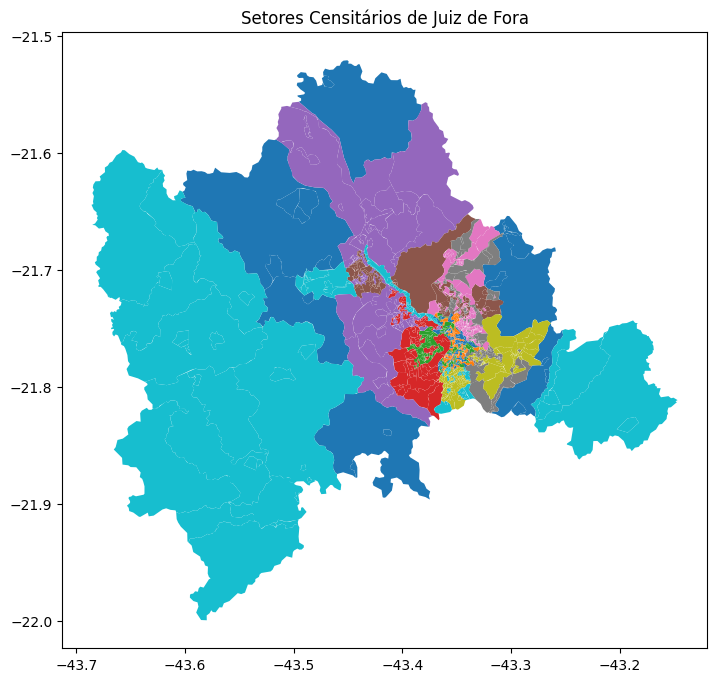

In [6]:
# Configurações
COD_MUNICIPIO = '3136702'
PATH_ZIP = "MG_setores_CD2022.zip"
PATH_EXTRACTED = "MG_setores_CD2022"
PATH_OUTPUT = "JF_setores"
MAX_FEATURES = 5000  # Limite máximo de features para carregar (ajuste conforme sua RAM)

# 1. Extração otimizada
if not os.path.exists(PATH_EXTRACTED):
    print("Descompactando arquivo ZIP...")
    with zipfile.ZipFile(PATH_ZIP, 'r') as zip_ref:
        # Extrai apenas os arquivos essenciais
        essential_files = [f for f in zip_ref.namelist() if f.endswith(('.shp', '.shx', '.dbf'))]
        for file in tqdm(essential_files, desc="Extraindo"):
            zip_ref.extract(file, PATH_EXTRACTED)

# 2. Carregamento otimizado
def load_and_filter():
    # Encontra o arquivo .shp
    shp_file = next((f for f in os.listdir(PATH_EXTRACTED) if f.endswith('.shp')), None)
    if not shp_file:
        raise FileNotFoundError("Arquivo .shp não encontrado na pasta extraída")
    
    shp_path = os.path.join(PATH_EXTRACTED, shp_file)
    
    # Carrega apenas as colunas necessárias
    print("Carregando e filtrando dados...")
    gdf = gpd.read_file(
        shp_path,
        rows=MAX_FEATURES,  # Limita a quantidade de registros
        columns=['CD_MUN', 'CD_SETOR', 'geometry'],  # Apenas colunas essenciais
        where=f"CD_MUN = '{COD_MUNICIPIO}'"  # Filtra diretamente na leitura
    )
    
    # Simplifica geometrias
    gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.0005)
    return gdf

# 3. Execução principal
if os.path.exists(f"{PATH_OUTPUT}.geojson"):
    print("Carregando dados processados...")
    gdf_jf = gpd.read_file(f"{PATH_OUTPUT}.geojson")
else:
    gdf_jf = load_and_filter()
    gdf_jf.to_file(f"{PATH_OUTPUT}.geojson", driver='GeoJSON')
    print(f"Dados salvos em {PATH_OUTPUT}.geojson")

# 4. Visualização segura
print(f"\nTotal de setores carregados: {len(gdf_jf)}")
if not gdf_jf.empty:
    # Criar a figura
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plotar o mapa
    gdf_jf.plot(ax=ax, column='CD_SETOR', legend=False)
    ax.set_title(f"Setores Censitários de Juiz de Fora")
    
    # Salvar como PNG
    plt.savefig('mapa_setores_jf.png', dpi=300, bbox_inches='tight')
    print("Mapa salvo como 'mapa_setores.png'")
    
    # Mostrar o mapa
    plt.show()
else:
    print("Nenhum dado foi carregado. Verifique o código do município.")

### Mapa coroplético 

Mapa coroplético é uma representação cartográfica que emprega cores, padrões ou tonalidades distintas em áreas delimitadas para visualizar a variação espacial do fenômeno estudado. Diferente de mapas de pontos ou agrupamentos, essa técnica enfatiza a distribuição de dados agregados por unidades territoriais pré-definidas, que nesse caso são os setores censitários.

In [7]:
# 1. Carregar e processar os dados
with zipfile.ZipFile('3136702_JUIZ_DE_FORA.zip') as z:
    with z.open('3136702_JUIZ_DE_FORA.csv') as f:
        chunks = pd.read_csv(f, 
                           sep=';',
                           chunksize=1000,
                           usecols=['COD_ESPECIE', 'COD_SETOR', 'LATITUDE', 'LONGITUDE'])
        
        filtered_data = pd.concat([chunk[chunk['COD_ESPECIE'] == 8] for chunk in chunks])

# 2. Agrupar por setor censitário
contagem_por_setor = filtered_data.groupby('COD_SETOR').size().reset_index(name='CONTAGEM')

# 3. Carregar geojson com os polígonos dos setores
try:
    with open('JF_setores.geojson') as f:
        geojson_data = json.load(f)
except FileNotFoundError:
    print("Arquivo GeoJSON não encontrado.")
    geojson_data = {
        "type": "FeatureCollection",
        "features": []
    }

# 4. Preparar os dados para o mapa coroplético
# Criar dicionário de contagem removendo o 'P' final para corresponder ao GeoJSON
contagem_dict = contagem_por_setor.copy()
contagem_dict['COD_SETOR'] = contagem_dict['COD_SETOR'].str.rstrip('P')
contagem_dict = contagem_dict.set_index('COD_SETOR')['CONTAGEM'].to_dict()

# Adicionar dados ao GeoJSON
for feature in geojson_data['features']:
    cod_setor = feature['properties']['CD_SETOR']
    feature['properties']['CONTAGEM'] = contagem_dict.get(cod_setor, 0)

# Verificação final dos dados
#print("\nVerificação final da correspondência:")
#for feature in geojson_data['features'][:5]:  # Mostrar apenas os 5 primeiros para exemplo
 #   cod = feature['properties']['CD_SETOR']
 #   print(f"Setor: {cod}, Contagem: {feature['properties']['CONTAGEM']}")

# 5. Criar o mapa coroplético
center_lat = filtered_data['LATITUDE'].mean()
center_lon = filtered_data['LONGITUDE'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Escala de cores
max_contagem = contagem_por_setor['CONTAGEM'].max()
colormap = cm.linear.YlOrRd_09.scale(0, max_contagem)

# Adicionar camada coroplética
folium.GeoJson(
    geojson_data,
    name='Densidade de Estabelecimentos Religiosos',
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['CONTAGEM']),
        'color': 'white',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
   # tooltip=folium.features.GeoJsonTooltip(
    #    fields=['CD_SETOR', 'CONTAGEM'],
     #   aliases=['Setor:', 'N° de Estabelecimentos:'],
      #  localize=True
   # )
).add_to(m)

# Adicionar legenda
colormap.caption = 'Densidade de estabelecimentos religiosos por Setor'
colormap.add_to(m)

# Adicionar controle de camadas
folium.LayerControl().add_to(m)

# Exibir o mapa
display(m)
m.save('mapa_coropletico_jf.html')

Referências:

CNEFE: https://www.ibge.gov.br/estatisticas/sociais/populacao/38734-cadastro-nacional-de-enderecos-para-fins-estatisticos.html

Dicionário de dados: https://ftp.ibge.gov.br/Cadastro_Nacional_de_Enderecos_para_Fins_Estatisticos/Censo_Demografico_2022/Arquivos_CNEFE/CSV/Dicionario_CNEFE_Censo_2022.xls

Mídia: https://g1.globo.com/mg/zona-da-mata/noticia/2024/02/03/juiz-de-fora-tem-mais-templos-religiosos-do-que-estabelecimentos-de-saude-e-de-ensino-juntos.ghtml